# **Assignment 2**

This assignment focuses on Airbnbs in Berlin, Germany. The goal is to help a company operating small and mid-size apartments hosting 2-6 guests. The company is set to price their new apartments not on the market. This assignment will build a prediction model for prices, and discuss the modeling decisions and compare the results to those of the case study. 

Task
• You may use other variables we used in class.

• You may do different feature engineering depending on the selected environment.

• You may make other sample design decisions!

• In each case, document your steps!

• Have at least 3 different models and compare performance

• Argue for your choice of models
- One model must be theoretically profound linear regression via OLS.
- One model must be Random Forest or any boosting algorithm

In [116]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import os
from pathlib import Path
import sys
import ast
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

In [265]:
# DATA IMPORT - FROM GITHUB
data = pd.read_csv('https://github.com/Iandrewburg/Assignment_1/raw/main/Assignment_2/berlin_airbnb.csv')

In [266]:
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3176.0,https://www.airbnb.com/rooms/3176,2.023090e+13,16/09/2023,city scrape,Rental unit in Berlin · ★4.63 · 1 bedroom · 2 ...,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/243355/84afcf...,3718,...,4.69,4.92,4.62,First name and Last name: Nicolas Krotz <br/> ...,f,1,1,0,0,0.85
1,9991.0,https://www.airbnb.com/rooms/9991,2.023090e+13,16/09/2023,city scrape,Rental unit in Berlin · ★5.0 · 4 bedrooms · 7 ...,4 bedroom with very large windows and outstand...,Prenzlauer Berg is an amazing neighbourhood wh...,https://a0.muscache.com/pictures/42799131/59c8...,33852,...,5.00,4.86,4.86,03/Z/RA/003410-18,f,1,1,0,0,0.08
2,14325.0,https://www.airbnb.com/rooms/14325,2.023090e+13,16/09/2023,city scrape,Rental unit in Berlin · ★4.67 · Studio · 1 bed...,The apartment is located on the upper second f...,NaN,https://a0.muscache.com/pictures/508703/24988a...,55531,...,4.84,4.58,4.42,NaN,f,4,4,0,0,0.16
3,16644.0,https://www.airbnb.com/rooms/16644,2.023090e+13,16/09/2023,city scrape,Condo in Berlin · ★4.72 · 1 bedroom · 1 bed · ...,Light and sunny 2-Room-turn of the century-fla...,Our Part of Kreuzberg is just the best. Good v...,https://a0.muscache.com/pictures/73759174/e2ef...,64696,...,4.86,4.67,4.71,NaN,f,2,2,0,0,0.30
4,17904.0,https://www.airbnb.com/rooms/17904,2.023090e+13,16/09/2023,city scrape,Rental unit in Berlin · ★4.77 · Studio · 1 bed...,"- apt is available starting April 1, 2023<br /...",NaN,https://a0.muscache.com/pictures/d9a6f8be-54b9...,68997,...,4.92,4.87,4.65,NaN,f,1,1,0,0,1.81


In [267]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [268]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13134 entries, 0 to 13133
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            13134 non-null  float64
 1   listing_url                                   13134 non-null  object 
 2   scrape_id                                     13134 non-null  float64
 3   last_scraped                                  13134 non-null  object 
 4   source                                        13134 non-null  object 
 5   name                                          13134 non-null  object 
 6   description                                   12997 non-null  object 
 7   neighborhood_overview                         6771 non-null   object 
 8   picture_url                                   13134 non-null  object 
 9   host_id                                       13134 non-null 

In [269]:
data.room_type.value_counts()

room_type
Entire home/apt    8431
Private room       4309
Shared room         262
Hotel room          132
Name: count, dtype: int64

In [270]:
data.property_type.value_counts()

property_type
Entire rental unit             6545
Private room in rental unit    3261
Entire condo                    756
Entire serviced apartment       407
Room in hotel                   297
                               ... 
Shared room in condo              1
Private room in boat              1
Treehouse                         1
Island                            1
Dome                              1
Name: count, Length: 67, dtype: int64

In [271]:
# check for missing values in the columns being focused on for this project
columns_missing_value = [
    'accommodates', 'beds', 'review_scores_rating', 'host_is_superhost',
    'host_since', 'number_of_reviews', 'availability_365', 'minimum_nights',
    'maximum_nights', 'property_type', 'room_type', 'price', 'amenities'
]

missing_values = data[columns_missing_value].isnull().sum()

missing_values

accommodates               0
beds                     162
review_scores_rating    2756
host_is_superhost         83
host_since                 9
number_of_reviews          0
availability_365           0
minimum_nights             0
maximum_nights             0
property_type              0
room_type                  0
price                      0
amenities                  0
dtype: int64

In [272]:
def airbnb_cleaner(data): 
    """
    Function that cleans the airbnb dataset for berlin to the desired dataframe.
    """
    
    
    """
    Step 1: Handling the amenities column. There are a lot of amenities, so this 
    will also filter for just the top 15 amenities by frequency.
    """
    # Convert the string representations of lists into actual lists
    data['amenities'] = data['amenities'].apply(lambda x: ast.literal_eval(x))

    # Flatten the list to count each amenity's occurrence
    all_amenities = [amenity for sublist in data['amenities'] for amenity in sublist]

    # Find the top 15 most frequent amenities
    amenities_series = pd.Series(all_amenities)
    top_15_amenities = amenities_series.value_counts().head(15).index.tolist()

    # Create binary variables for these top 15 amenities
    for amenity in top_15_amenities:
        # Correctly format column names by replacing spaces with underscores
        # Ensure any potential quotes are handled correctly
        column_name = "amenities_" + amenity.replace(' ', '_').replace('"', '')
        data[column_name] = data['amenities'].apply(lambda x: 1 if amenity in x else 0)
    
    
    
    """
    Step 2: Remove unnecessary columns for this project.
    """
    # Define the top amenities columns to keep
    top_amenities_columns = [
        'amenities_Kitchen', 'amenities_Wifi', 'amenities_Essentials', 'amenities_Hair_dryer', 'amenities_Heating',
        'amenities_Hangers', 'amenities_Smoke_alarm', 'amenities_Hot_water', 'amenities_Dishes_and_silverware',
        'amenities_Washer', 'amenities_Iron', 'amenities_Refrigerator', 'amenities_Cooking_basics',
        'amenities_Bed_linens', 'amenities_Shampoo'
    ]
    
    # columns to keep
    columns = list(set([
        'accommodates', 'beds', 'review_scores_rating', 'host_is_superhost',
        'number_of_reviews',
        'availability_365', 'minimum_nights', 'maximum_nights', 'property_type',
        'room_type', 'price'
    ] + top_amenities_columns))

    # Creating a new DataFrame with only the selected columns
    data = data[columns]
    
    
    
    """
    Step  : Take care of missing values and data types
    """
    data['accommodates'] = data['accommodates'].fillna(0).astype(int)
    data['beds'] = data['beds'].fillna(0).astype(int)
    data['review_scores_rating'] = data['review_scores_rating'].fillna(0)
    data['number_of_reviews'] = data['number_of_reviews'].fillna(0).astype(int)
    data['availability_365'] = data['availability_365'].fillna(0).astype(int)
    data['minimum_nights'] = data['minimum_nights'].fillna(0).astype(int)
    data['maximum_nights'] = data['maximum_nights'].fillna(0).astype(int)
    data['property_type'] = data['property_type'].fillna("Missing")
    data['room_type'] = data['room_type'].fillna("Missing")
    
    
    
    """
    Step 3: Clean the price column.
    """
    # Remove 0 values
    data = data[data['price'] != 0]
    
    # Drop null values
    data = data.dropna(subset=['price'])
    
    # Remove $ sign and change type to numeric
    data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float).astype(int)
    
    
    
    """
    Step 4: Filter the dataset. The following filtering is conducted: 
    - Listings that accomodate 2-6 people
    - The IQR of prices
    - Excluding hotel listings
    """
    # Calculate price IQR
    Q1, Q3 = data['price'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    # Filters
    data = data[
        (data['accommodates'] >= 2) & 
        (data['accommodates'] <= 6) & 
        (data['price'] >= lower_bound) & 
        (data['price'] <= upper_bound) & 
        ~((data['property_type'] == 'Room in hotel') & (data['room_type'] == 'Hotel room'))
    ] 
    
    
    """
    Step 5: Handle the 'property_type' and 'room_type' columns.
    
    There are a lot of property types, so any property types with
    under 100 values were removed so that only the top property 
    types were analyzed. 
    
    The remaining property types and room types categories were then 
    transformed to binary variables. 
    """
    # Remove property types that appear in less than 100 listings
    property_type_value_counts = data['property_type'].value_counts()
    to_remove = property_type_value_counts[property_type_value_counts < 100].index
    data = data[~data['property_type'].isin(to_remove)]
    
    # Create dummy variables for 'property_type' and concatenate them with the main DataFrame
    property_dummies = pd.get_dummies(data['property_type'], prefix='d_type')
    data = pd.concat([data, property_dummies], axis=1)

    # Create dummy variables for 'room_type' and concatenate them with the main DataFrame
    room_dummies = pd.get_dummies(data['room_type'], prefix='d_room')
    data = pd.concat([data, room_dummies], axis=1)

    # Ensure dummy columns created for 'property_type' and 'room_type' are of integer type
    d_columns = data.columns[data.columns.str.startswith('d_')]
    data[d_columns] = data[d_columns].astype(int)
    
    
    """
    Step 6: Renaming columns
    
    All spaces in column names were replaced with an underscore. 
    Furthermore, the column names were made to be lowercase
    
    Columns were then manulally renamed for more efficient naming
    """
    # Rename all columns to lowercase and replace spaces with underscores
    data.rename(columns=lambda x: x.replace(" ", "_").lower(), inplace=True)
    
    # Further rename specific columns with prefixes
    data = data.rename(columns={
        'review_scores_rating': 'n_review_scores_rating',
        'minimum_nights': 'n_minimum_nights',
        'accommodates': 'n_accommodates',
        'beds': 'n_beds',
        'availability_365': 'n_availability_365',
        'number_of_reviews': 'n_number_of_reviews',
        'maximum_nights': 'n_maximum_nights',
        'room_type': 'f_room_type',
        'property_type': 'f_property_type',
        'd_room_entire_home/apt': 'd_room_entire_apt',
        'host_is_superhost': 'd_host_is_superhost'
    })

    data['d_host_is_superhost'] = data['d_host_is_superhost'].map({'t': 1, 'f': 0}).fillna(0).astype(int)
    # resort the data by alphabetical order
    data = data.reindex(sorted(data.columns), axis=1)
    
    return data

data = airbnb_cleaner(data)

data

,amenities_bed_linens,amenities_cooking_basics,amenities_dishes_and_silverware,amenities_essentials,amenities_hair_dryer,amenities_hangers,amenities_heating,amenities_hot_water,amenities_iron,amenities_kitchen,...,f_property_type,f_room_type,n_accommodates,n_availability_365,n_beds,n_maximum_nights,n_minimum_nights,n_number_of_reviews,n_review_scores_rating,price
0,0,1,0,1,1,1,1,0,1,1,...,Entire rental unit,Entire home/apt,4,123,2,184,63,148,4.63,83
3,0,0,0,1,1,1,1,0,1,1,...,Entire condo,Entire home/apt,4,131,1,365,93,48,4.72,90
4,0,1,1,1,1,1,1,1,1,1,...,Entire rental unit,Entire home/apt,2,10,1,365,92,299,4.77,25
5,0,1,1,1,1,1,1,1,1,1,...,Entire loft,Entire home/apt,4,134,2,30,3,116,4.49,179
6,1,1,1,1,1,1,1,1,1,1,...,Entire rental unit,Entire home/apt,2,77,2,730,93,60,4.74,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13129,0,0,0,0,0,0,0,0,0,1,...,Entire rental unit,Entire home/apt,2,238,1,365,1,0,0.00,100
13130,0,0,0,0,0,0,0,0,0,1,...,Entire rental unit,Entire home/apt,2,16,1,365,5,0,0.00,90
13131,0,0,0,0,0,0,0,0,0,1,...,Entire rental unit,Entire home/apt,2,25,1,365,5,0,0.00,95
13132,0,0,0,0,0,0,0,0,0,1,...,Entire rental unit,Entire home/apt,5,262,2,365,3,0,0.00,130


In [273]:
# double check missing values
missing_values_count = data.isnull().sum()

missing_values_table = pd.DataFrame(missing_values_count, columns=['Missing Values'])

missing_values_table

,Missing Values
amenities_bed_linens,0
amenities_cooking_basics,0
amenities_dishes_and_silverware,0
amenities_essentials,0
amenities_hair_dryer,0
amenities_hangers,0
amenities_heating,0
amenities_hot_water,0
amenities_iron,0
amenities_kitchen,0


In [274]:
data.dtypes

amenities_bed_linens                    int64
amenities_cooking_basics                int64
amenities_dishes_and_silverware         int64
amenities_essentials                    int64
amenities_hair_dryer                    int64
amenities_hangers                       int64
amenities_heating                       int64
amenities_hot_water                     int64
amenities_iron                          int64
amenities_kitchen                       int64
amenities_refrigerator                  int64
amenities_shampoo                       int64
amenities_smoke_alarm                   int64
amenities_washer                        int64
amenities_wifi                          int64
d_host_is_superhost                     int32
d_room_entire_apt                       int32
d_room_private_room                     int32
d_type_entire_condo                     int32
d_type_entire_home                      int32
d_type_entire_loft                      int32
d_type_entire_rental_unit         

In [275]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9832 entries, 0 to 13133
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   amenities_bed_linens                9832 non-null   int64  
 1   amenities_cooking_basics            9832 non-null   int64  
 2   amenities_dishes_and_silverware     9832 non-null   int64  
 3   amenities_essentials                9832 non-null   int64  
 4   amenities_hair_dryer                9832 non-null   int64  
 5   amenities_hangers                   9832 non-null   int64  
 6   amenities_heating                   9832 non-null   int64  
 7   amenities_hot_water                 9832 non-null   int64  
 8   amenities_iron                      9832 non-null   int64  
 9   amenities_kitchen                   9832 non-null   int64  
 10  amenities_refrigerator              9832 non-null   int64  
 11  amenities_shampoo                   9832 non-nu

In [276]:
data.isna().sum().sum()

0

In [277]:
data.shape

(9832, 37)

In [278]:
data.columns

Index(['amenities_bed_linens', 'amenities_cooking_basics',
       'amenities_dishes_and_silverware', 'amenities_essentials',
       'amenities_hair_dryer', 'amenities_hangers', 'amenities_heating',
       'amenities_hot_water', 'amenities_iron', 'amenities_kitchen',
       'amenities_refrigerator', 'amenities_shampoo', 'amenities_smoke_alarm',
       'amenities_washer', 'amenities_wifi', 'd_host_is_superhost',
       'd_room_entire_apt', 'd_room_private_room', 'd_type_entire_condo',
       'd_type_entire_home', 'd_type_entire_loft', 'd_type_entire_rental_unit',
       'd_type_entire_serviced_apartment', 'd_type_private_room_in_condo',
       'd_type_private_room_in_home', 'd_type_private_room_in_rental_unit',
       'd_type_room_in_hotel', 'f_property_type', 'f_room_type',
       'n_accommodates', 'n_availability_365', 'n_beds', 'n_maximum_nights',
       'n_minimum_nights', 'n_number_of_reviews', 'n_review_scores_rating',
       'price'],
      dtype='object')

### EDA

In [279]:
# copy a variable - purpose later, see at variable importance
data['n_accommodates_copy'] = data['n_accommodates']

***numerical variables***

In [280]:
# too long to display and read
data.describe().T

,count,mean,std,min,25%,50%,75%,max
amenities_bed_linens,9832.0,0.532547,0.498965,0.0,0.00,1.00,1.00,1.0
amenities_cooking_basics,9832.0,0.584215,0.492882,0.0,0.00,1.00,1.00,1.0
amenities_dishes_and_silverware,9832.0,0.619711,0.485482,0.0,0.00,1.00,1.00,1.0
amenities_essentials,9832.0,0.859439,0.347586,0.0,1.00,1.00,1.00,1.0
amenities_hair_dryer,9832.0,0.735557,0.441058,0.0,0.00,1.00,1.00,1.0
amenities_hangers,9832.0,0.682567,0.465501,0.0,0.00,1.00,1.00,1.0
amenities_heating,9832.0,0.714199,0.451818,0.0,0.00,1.00,1.00,1.0
amenities_hot_water,9832.0,0.655919,0.475092,0.0,0.00,1.00,1.00,1.0
amenities_iron,9832.0,0.591131,0.491650,0.0,0.00,1.00,1.00,1.0
amenities_kitchen,9832.0,0.942535,0.232742,0.0,1.00,1.00,1.00,1.0


***categorical variables***

In [281]:
data.f_room_type.value_counts()

f_room_type
Entire home/apt    7050
Private room       2782
Name: count, dtype: int64

In [282]:
data.f_property_type.value_counts()

f_property_type
Entire rental unit             5805
Private room in rental unit    2309
Entire condo                    673
Entire serviced apartment       246
Entire loft                     220
Private room in condo           179
Room in hotel                   170
Private room in home            124
Entire home                     106
Name: count, dtype: int64

***split train and test***
- train is where we do it all, incl CV

- first pick a smaller than usual training set so that models run faster and check if works
- if works, start anew without these two lines

In [285]:
# Splitting the dataset into training and holdout sets to prepare for model training and validation.
# A 70% training set size is chosen initially to speed up model runs during the exploratory phase.
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)

# Display the shapes of the training and holdout sets to verify the split.
print(data_train.shape, data_holdout.shape)

# Basic predictor variables selected for the model based on data understanding.
basic_vars = [
    "n_accommodates", "n_beds", "f_property_type", "f_room_type",
    "d_host_is_superhost", "n_availability_365", "n_maximum_nights", "n_minimum_nights",
]

# Variables related to reviews to be used as predictors in the model.
reviews = ["n_number_of_reviews", "n_review_scores_rating"]

# Dynamic list creation for amenities-related variables to be used as predictors.
amenities = [col for col in data.columns if col.startswith("amenities_")]

# Dynamic list creation for room booking types to be used as predictors.
room_booking_types = [col for col in data.columns if col.startswith("d_")]

# Interaction terms involving property and room types with the number of accommodates.
X1 = ["f_property_type:n_accommodates", "f_room_type:n_accommodates"]

# Interaction terms involving price with host characteristics and listing features.
X2 = ["price:d_host_is_superhost", "n_accommodates:price", "n_beds:price"]

# More complex interaction terms combining various features to capture nuanced relationships.
X3 = [
    # Interactions involving property types, room types, and number of accommodates.
    "f_property_type:n_accommodates:f_room_type", "f_property_type:n_review_scores_rating", "f_room_type:n_review_scores_rating",
    # Interactions with amenities.
    "amenities_wifi:n_accommodates", "amenities_kitchen:n_accommodates",
    # Host characteristics and listing features.
    "d_host_is_superhost:n_review_scores_rating", "d_host_is_superhost:price",
    # Incorporating time aspects to represent host experience.
    "date_host_start:n_review_scores_rating", "date_host_start:price",
    # Detailed interactions with amenities.
    "amenities_essentials:amenities_hair_dryer:n_accommodates", "amenities_essentials:amenities_hair_dryer:price",
    # Cross-amenity interactions.
    "amenities_kitchen:amenities_washer:n_accommodates", "amenities_wifi:amenities_kitchen:n_review_scores_rating",
]

# Defining predictor sets for different modeling approaches.
predictors_1 = basic_vars  # Only basic variables.
predictors_2 = basic_vars + reviews + amenities + room_booking_types  # Basic, review, amenities, and booking types.
predictors_E = basic_vars + reviews + amenities + room_booking_types + X1 + X2 + X3  # All inclusive with interactions.


(6882, 38) (2950, 38)


### Random Forest

In [286]:
# Prepare the design matrices for the outcome variable 'price' and predictors from 'data_train' using the patsy dmatrices function.
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

# Check the type of the design matrix X, which is a patsy design matrix.
print(type(X))

# Display the design matrix X to see its content.
X


<class 'patsy.design_info.DesignMatrix'>


DesignMatrix with shape (6882, 44)
  Columns:
    ['Intercept',
     'f_property_type[T.Entire home]',
     'f_property_type[T.Entire loft]',
     'f_property_type[T.Entire rental unit]',
     'f_property_type[T.Entire serviced apartment]',
     'f_property_type[T.Private room in condo]',
     'f_property_type[T.Private room in home]',
     'f_property_type[T.Private room in rental unit]',
     'f_property_type[T.Room in hotel]',
     'f_room_type[T.Private room]',
     'n_accommodates',
     'n_beds',
     'd_host_is_superhost',
     'n_availability_365',
     'n_maximum_nights',
     'n_minimum_nights',
     'n_number_of_reviews',
     'n_review_scores_rating',
     'amenities_bed_linens',
     'amenities_cooking_basics',
     'amenities_dishes_and_silverware',
     'amenities_essentials',
     'amenities_hair_dryer',
     'amenities_hangers',
     'amenities_heating',
     'amenities_hot_water',
     'amenities_iron',
     'amenities_kitchen',
     'amenities_refrigerator',
     'am

In [287]:
# Get and display the column names of X, which are the names of the predictors used in the model.
print(X.design_info.column_names)

# Convert the design matrix X to a NumPy array for compatibility with scikit-learn models.
np.asarray(X)

['Intercept', 'f_property_type[T.Entire home]', 'f_property_type[T.Entire loft]', 'f_property_type[T.Entire rental unit]', 'f_property_type[T.Entire serviced apartment]', 'f_property_type[T.Private room in condo]', 'f_property_type[T.Private room in home]', 'f_property_type[T.Private room in rental unit]', 'f_property_type[T.Room in hotel]', 'f_room_type[T.Private room]', 'n_accommodates', 'n_beds', 'd_host_is_superhost', 'n_availability_365', 'n_maximum_nights', 'n_minimum_nights', 'n_number_of_reviews', 'n_review_scores_rating', 'amenities_bed_linens', 'amenities_cooking_basics', 'amenities_dishes_and_silverware', 'amenities_essentials', 'amenities_hair_dryer', 'amenities_hangers', 'amenities_heating', 'amenities_hot_water', 'amenities_iron', 'amenities_kitchen', 'amenities_refrigerator', 'amenities_shampoo', 'amenities_smoke_alarm', 'amenities_washer', 'amenities_wifi', 'd_room_entire_apt', 'd_room_private_room', 'd_type_entire_condo', 'd_type_entire_home', 'd_type_entire_loft', 'd_

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [288]:
# Calculate and print the theoretical recommended number of variables for Random Forest based on the square root of the number of features.
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))


The theoretical recommended number of variables: 6.63.


In [289]:
# Display the shape of X to understand its dimensions (number of observations and features).
print("Shape of X")
print(X.shape)
print("-"*25)


# Display the shape of y to understand its dimensions, indicating it's a two-dimensional object.
# a two-dimensional object
print("Shape of y")
print(y.shape)
print("-"*25)


# Check the type of the outcome variable y, which is a patsy design matrix.
print("variable type of y")
print(type(y))
print("-"*25)


# Flatten the y array to a one-dimensional data object using ravel(), making it compatible with scikit-learn models.
# using ravel() we flatten it to a one-dimensional data object. 
print("flatten y to become one-dimensional")
print(y.ravel().shape)
print("-"*25)

Shape of X
(6882, 44)
-------------------------
Shape of y
(6882, 1)
-------------------------
variable type of y
<class 'patsy.design_info.DesignMatrix'>
-------------------------
flatten y to become one-dimensional
(6882,)
-------------------------


In [290]:
# Initialize the Random Forest Regressor with a specific random state for reproducibility.
rfr = RandomForestRegressor(random_state=20240211)

# Define a parameter grid for tuning the Random Forest model via GridSearchCV.
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

# Setup GridSearchCV with the Random Forest regressor, the tuning parameter grid, 5-fold cross-validation, 
# and neg_root_mean_squared_error as the scoring metric. The verbose parameter is for logging the progress.
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [291]:
%%time
rf_model = rf_random.fit(X, y.ravel())

# Fit the GridSearchCV to the data, finding the best model parameters.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-35.668 total time=   0.6s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-38.582 total time=   0.6s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-37.822 total time=   0.5s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-38.203 total time=   0.5s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-39.261 total time=   0.4s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-36.171 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-39.339 total time=   0.4s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-38.462 total time=   0.3s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-38.906 total time=   0.4s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-39.633 total time=   0.3s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-36.705 total time=   0.4s
[CV 2/5] END max_fea

In [292]:
# Display the cross-validation results of the GridSearch.
rf_model.cv_results_


{'mean_fit_time': array([0.57015953, 0.43297997, 0.46504931, 0.69692683, 0.59782133,
        0.50492721, 0.77814155, 0.65411487, 0.58061085, 0.93196325,
        0.77303777, 0.69042678]),
 'std_fit_time': array([0.05370759, 0.00974268, 0.03022818, 0.0232863 , 0.03177282,
        0.02289682, 0.02153376, 0.01079731, 0.00710494, 0.01823781,
        0.01788547, 0.01851973]),
 'mean_score_time': array([0.02629924, 0.02180362, 0.02589025, 0.02711868, 0.02390618,
        0.02128277, 0.02609544, 0.02442036, 0.02125325, 0.02836404,
        0.02540474, 0.02232432]),
 'std_score_time': array([0.00230917, 0.00111995, 0.00219221, 0.00053919, 0.00254469,
        0.00167168, 0.00039452, 0.00158394, 0.00112141, 0.00159109,
        0.00223998, 0.00145634]),
 'param_max_features': masked_array(data=[6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dty

In [293]:
# Create a DataFrame from the cv_results_ to focus on max features, min samples leaf, and mean test score (RMSE),
# and rename the columns for clarity.
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

# Display the formatted DataFrame.
df_rf_model_cv_results


,max features,min node size,RMSE
0,6,5,-37.907252
1,6,10,-38.502248
2,6,15,-38.970635
3,8,5,-37.670025
4,8,10,-38.136580
5,8,15,-38.540961
6,10,5,-37.511696
7,10,10,-37.939379
8,10,15,-38.351795
9,12,5,-37.449600


In [294]:
# Pivot the DataFrame to better visualize the impact of max features and min node size on RMSE.
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1


min node size,5,10,15
max features,,,
6,37.91,38.50,38.97
8,37.67,38.14,38.54
10,37.51,37.94,38.35
12,37.45,37.91,38.26


In [295]:
# Display the best score from GridSearchCV (negated back to positive for interpretability).
rf_model.best_score_


-37.44959968023793

In [296]:
# Display the best parameter combination found by GridSearchCV.
rf_model.best_params_


{'max_features': 12, 'min_samples_leaf': 5}

In [297]:
# Display the best estimator model.
rf_model.best_estimator_


RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240211)

### Diagnostics: Feature Importances ###

**individual**

In [298]:
# Display feature importances from the best Random Forest model.
rf_model.best_estimator_.feature_importances_


array([0.00000000e+00, 2.08633894e-04, 1.78402066e-03, 5.70320430e-03,
       2.00902243e-02, 1.47007345e-03, 2.77653649e-03, 5.85411624e-02,
       1.96135267e-02, 2.27553206e-02, 1.31585894e-01, 3.17046848e-02,
       6.27298901e-03, 1.21361883e-01, 3.74549037e-02, 2.15936226e-01,
       4.34222889e-02, 3.30935999e-02, 1.43388310e-02, 5.09489373e-03,
       4.95971177e-03, 2.65662517e-03, 3.98942088e-03, 4.62371605e-03,
       7.40087052e-03, 4.58465920e-03, 6.89800840e-03, 2.67814302e-03,
       5.53987296e-03, 9.81767565e-03, 1.51274554e-02, 7.28836394e-03,
       4.29194492e-03, 2.39294720e-02, 2.55553201e-02, 1.96696471e-03,
       1.43331749e-04, 1.61233379e-03, 4.76639191e-03, 2.29959835e-02,
       7.86950133e-04, 3.27888083e-03, 4.27749648e-02, 1.91240411e-02])

In [299]:
# Create a DataFrame mapping feature importances to their corresponding variable names.
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)


,0
Intercept,0.000000
f_property_type[T.Entire home],0.000209
f_property_type[T.Entire loft],0.001784
f_property_type[T.Entire rental unit],0.005703
f_property_type[T.Entire serviced apartment],0.020090
f_property_type[T.Private room in condo],0.001470
f_property_type[T.Private room in home],0.002777
f_property_type[T.Private room in rental unit],0.058541
f_property_type[T.Room in hotel],0.019614
f_room_type[T.Private room],0.022755


In [300]:
# Further process the DataFrame to include variable names, importances, sort by importance, 
# and reset the index for a clean look. Also, calculate cumulative importance.
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()


In [301]:
# Format the DataFrame to display importances as percentages.
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})


,variable,imp,cumulative_imp
0,n_minimum_nights,21.6%,21.6%
1,n_accommodates,13.2%,34.8%
2,n_availability_365,12.1%,46.9%
3,f_property_type[T.Private room in rental unit],5.9%,52.7%
4,n_number_of_reviews,4.3%,57.1%
5,d_type_private_room_in_rental_unit,4.3%,61.4%
6,n_maximum_nights,3.7%,65.1%
7,n_review_scores_rating,3.3%,68.4%
8,n_beds,3.2%,71.6%
9,d_room_private_room,2.6%,74.1%


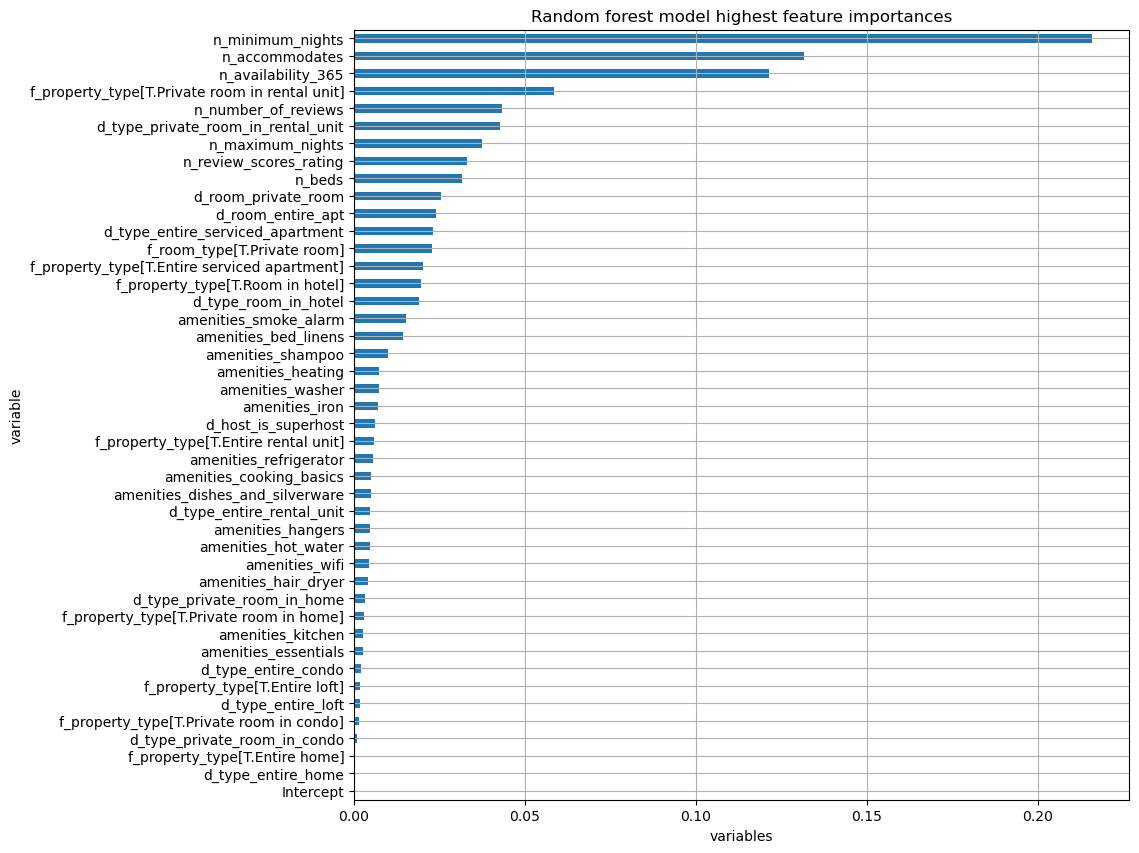

In [302]:
# Format the DataFrame to display importances as percentages.
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );


In [303]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

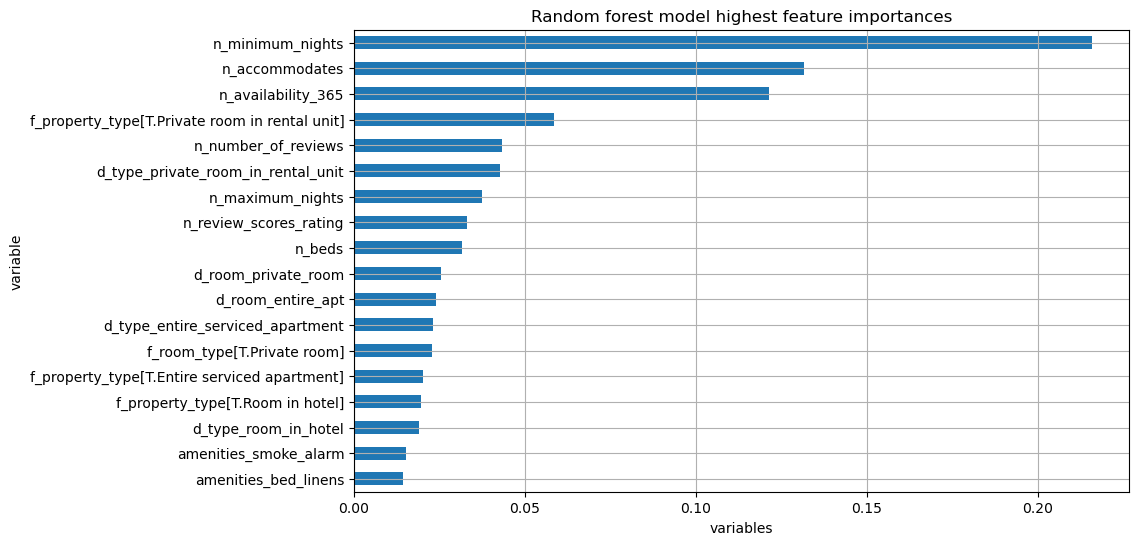

In [304]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

***grouped variable importance - keep binaries created off factors together***

For this, you need to create an `sklearn` Pipeline inclduing `OneHotEncoding` (before, encoding was done by patsy's `dmatrices`). This way permutation_importance can calculate factor variables' importance 

In [305]:
# Identify categorical and numerical columns from the predictors to prepare for preprocessing.
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]


In [306]:
# Initialize OneHotEncoder for categorical variables to handle unseen categories during transformation.
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

# Setup preprocessing steps: one-hot encode categorical variables and pass through numerical variables.
preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

# Setup preprocessing steps: one-hot encode categorical variables and pass through numerical variables.
rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)


In [307]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

# Fit the pipeline on the training data, ensuring that data is preprocessed before fitting the model.

ValueError: Selected columns, ['n_accommodates', 'n_beds', 'd_host_is_superhost', 'n_availability_365', 'n_maximum_nights', 'n_minimum_nights', 'n_number_of_reviews', 'n_review_scores_rating', 'amenities_bed_linens', 'amenities_cooking_basics', 'amenities_dishes_and_silverware', 'amenities_essentials', 'amenities_hair_dryer', 'amenities_hangers', 'amenities_heating', 'amenities_hot_water', 'amenities_iron', 'amenities_kitchen', 'amenities_refrigerator', 'amenities_shampoo', 'amenities_smoke_alarm', 'amenities_washer', 'amenities_wifi', 'd_host_is_superhost', 'd_room_entire_apt', 'd_room_private_room', 'd_type_entire_condo', 'd_type_entire_home', 'd_type_entire_loft', 'd_type_entire_rental_unit', 'd_type_entire_serviced_apartment', 'd_type_private_room_in_condo', 'd_type_private_room_in_home', 'd_type_private_room_in_rental_unit', 'd_type_room_in_hotel'], are not unique in dataframe

In [308]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

# Calculate permutation importance on the holdout set to evaluate the importance of features,
# using 10 repeats for stability of importance estimation.

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [309]:

result


{'importances_mean': array([ 1.15464391e-01,  7.64350710e-03,  5.53733372e-02,  2.12437518e-02,
         1.87136779e-03,  6.84961400e-02,  1.30864304e-02,  2.20794785e-01,
         1.45927570e-02,  1.19735043e-02,  8.67516665e-03,  2.22373613e-03,
         1.16503195e-03,  4.08970466e-04,  1.50307589e-03,  8.72577942e-04,
         3.38314874e-03,  1.81814717e-03,  2.34171352e-03,  2.79815010e-03,
         1.57794119e-03,  4.74777378e-03,  5.56774779e-03,  2.91864837e-03,
         1.29842189e-03,  5.45404257e-03,  2.24041877e-04,  1.31315989e-02,
        -1.01193909e-04, -5.19396065e-05, -1.32813213e-03,  1.01086358e-03,
         7.58098825e-03,  2.65318723e-05,  7.93099234e-04,  1.14172901e-02,
         1.72284818e-02]),
 'importances_std': array([8.13744681e-03, 1.01562502e-03, 2.83774177e-03, 3.13563253e-03,
        3.48110794e-04, 2.79012992e-03, 1.75353696e-03, 9.26006337e-03,
        2.15065013e-03, 1.96380412e-03, 1.24156612e-03, 8.43433442e-04,
        3.81597751e-04, 1.98068884

In [310]:
# Create a DataFrame to display the mean importance of each feature.
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)


,0
n_accommodates,0.115464
n_beds,0.007644
f_property_type,0.055373
f_room_type,0.021244
d_host_is_superhost,0.001871
n_availability_365,0.068496
n_maximum_nights,0.013086
n_minimum_nights,0.220795
n_number_of_reviews,0.014593
n_review_scores_rating,0.011974


In [315]:

grouped = [
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "d_host_is_superhost",
    "n_availability_365",
    "n_maximum_nights",
    "n_minimum_nights",
]


In [316]:
# Grouped variable importance for selected variables, focusing on the predefined 'grouped' list.
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

# Calculate and format cumulative importance for grouped variables.
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()


In [317]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})


,variable,imp,cumulative_imp
0,n_minimum_nights,22.1%,22.1%
1,n_accommodates,11.5%,33.6%
2,n_availability_365,6.8%,40.5%
3,f_property_type,5.5%,46.0%
4,f_room_type,2.1%,48.1%
5,n_maximum_nights,1.3%,49.4%
6,n_beds,0.8%,50.2%
7,d_host_is_superhost,0.5%,50.8%
8,d_host_is_superhost,0.2%,50.9%


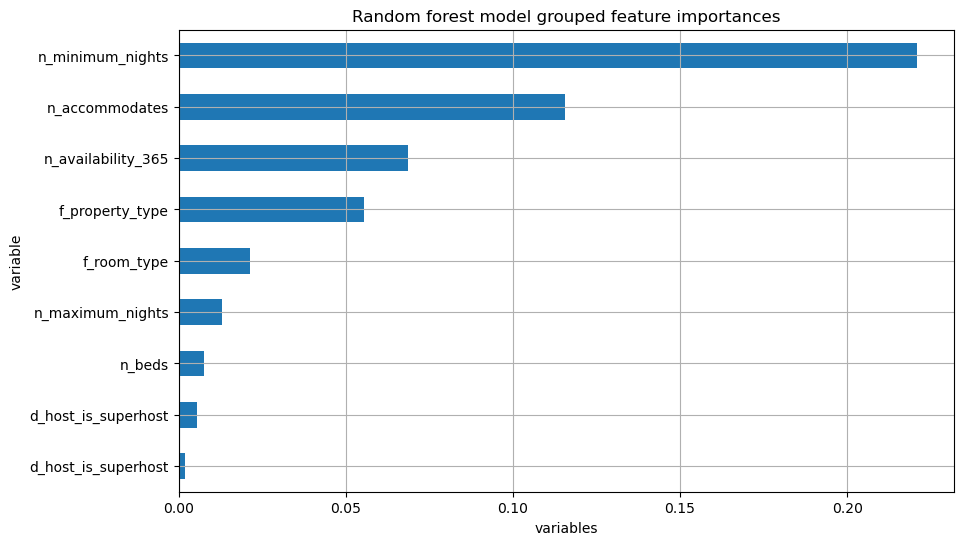

In [318]:
# Visualize the feature importances for grouped variables in a bar chart.
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );


In [319]:
# Create a cleaned DataFrame of variable importances, focusing on variables contributing to 91% of the importance.
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]


,variable,imp,cumulative_imp
0,n_minimum_nights,0.220795,0.215936
1,n_accommodates,0.115464,0.347522
2,n_availability_365,0.068496,0.468884
3,f_property_type,0.055373,0.527425
4,f_room_type,0.021244,0.570847
5,d_type_room_in_hotel,0.017228,0.613622
6,n_number_of_reviews,0.014593,0.651077
7,d_room_private_room,0.013132,0.684171
8,n_maximum_nights,0.013086,0.715876
9,n_review_scores_rating,0.011974,0.741431


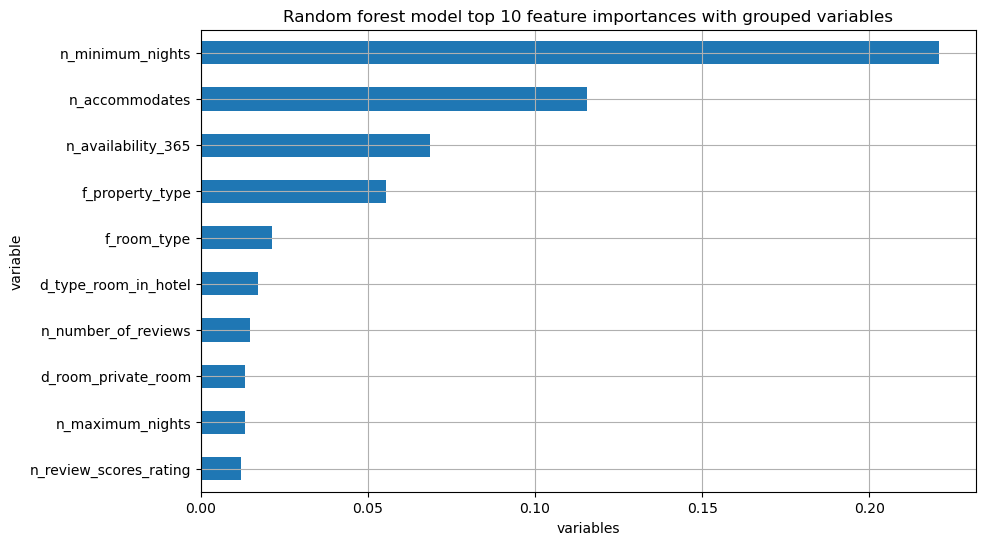

In [320]:
# Visualize the top 10 important features with grouped variables in a bar chart.
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );


### Partial dependence plots 

Note: easy way, sklearn has plot_partial_dependence function we do this on holdout set!   
Also, note that we run it not on the `rf_model` but on the `rf_pipeline` to manage OneHot_Encoding on the fly.

In [325]:
# Generate a partial dependence plot for 'n_accommodates' using the fitted Random Forest pipeline.
# This step calculates the effect of 'n_accommodates' on the predicted 'price' while holding other predictors constant.
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)


ValueError: feature_names should not contain duplicates.

In [322]:
# Display the partial dependence object to inspect its contents.
accomodates_pdp


{'grid_values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'average': array([[ 88.86571572,  93.5117452 , 109.73846796, 118.7340809 ,
         120.42154302]])}

In [323]:
# Check the type of the partial dependence result to understand its structure for further processing.
# We need to access the elements of this complex data structure
type(accomodates_pdp)


sklearn.utils._bunch.Bunch

In [324]:
# Create a DataFrame from the partial dependence results.
# This DataFrame maps the number of accommodations to the average predicted price, showing the relationship.
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )


,number of accomodates,average price
0,2,88.865716
1,3,93.511745
2,4,109.738468
3,5,118.734081
4,6,120.421543


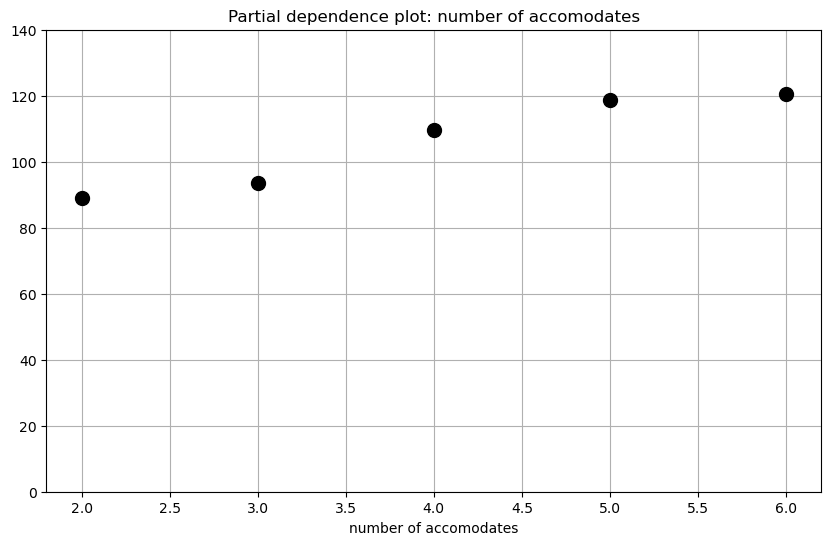

In [189]:
# Plot the relationship between 'number of accomodates' and 'average price' as a line plot.
# This visualization helps interpret how changes in the number of accommodations relate to the pricing.
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: number of accomodates'
);


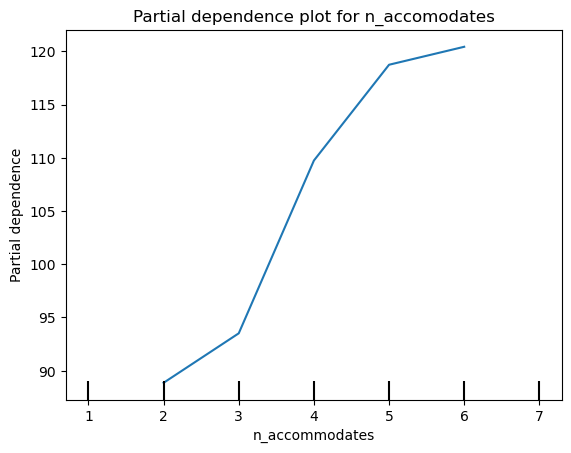

In [190]:
# Utilize PartialDependenceDisplay for a more standardized visualization of the partial dependence plot.
# This approach allows for easier integration and customization of the plot presentation.
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 7, num=7)} # Deciles provide a way to segment the feature values for visualization.
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();


In [191]:
# Repeat the process for 'f_room_type' to understand its impact on the predicted 'price'.
# Generate a partial dependence plot, create a DataFrame from the results, and visualize the relationship.
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["f_room_type"], kind="average"
)


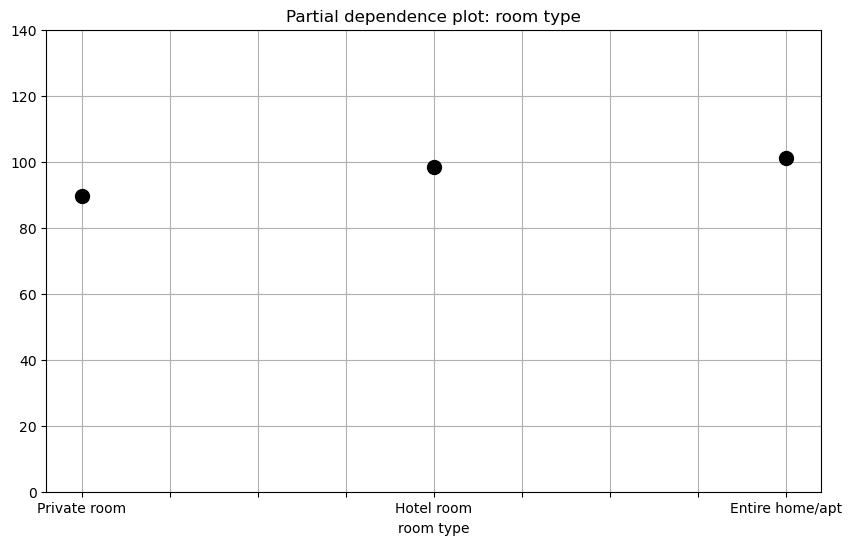

In [192]:
# This DataFrame and plot showcase how different room types relate to the average predicted price,
# highlighting the effect of room type on pricing decisions.
pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: room type'
);


### Horserace: compare with other models 

**NOTE: this part of the code is not finished**

1. ***OLS with dummies for area***

 using model B

In [193]:
# Import the LinearRegression class from sklearn.linear_model for OLS regression.
from sklearn.linear_model import LinearRegression


In [194]:
# Prepare the outcome variable 'y' and predictor variables 'X' using dmatrices,
# which automatically handles categorical variables by creating dummy variables.
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

# Initialize the OLS model and fit it to the data. This step computes the coefficient estimates.
ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

# Predict the dependent variable 'y' using the fitted model and the predictors 'X'.
y_hat = ols_model.predict(X)

# Calculate the root mean squared error (RMSE) to evaluate the model's accuracy.
# RMSE is the square root of the average squared differences between the predicted and actual values.
ols_rmse = mean_squared_error(y,y_hat,squared=False)

# Display the RMSE value, which provides a measure of how well the model predicts the dependent variable.
# Lower RMSE values indicate a better fit to the data.
ols_rmse


39.863833632728074

In [195]:
# Create a DataFrame containing the OLS model coefficients for each predictor.
# Coefficients represent the estimated change in the dependent variable for a one-unit change in the predictor,
# holding all other predictors constant.
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0], # Extract the coefficients from the model.
    index=X.design_info.column_names, # Use predictor variable names as the DataFrame index.
    columns=["ols_coefficient"], # Name the column holding the coefficients.
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3)) # Round coefficients for readability.


In [196]:
# Display the coefficients DataFrame.
# Positive coefficients indicate a positive relationship between the predictor and the dependent variable,
# while negative coefficients indicate a negative relationship.
ols_model_coeffs_df


,ols_coefficient
Intercept,0.000
f_property_type[T.Entire home],-12.216
f_property_type[T.Entire loft],8.056
f_property_type[T.Entire rental unit],-7.240
f_property_type[T.Entire serviced apartment],24.098
f_property_type[T.Private room in condo],-11.007
f_property_type[T.Private room in home],-21.488
f_property_type[T.Private room in rental unit],-10.044
f_property_type[T.Room in hotel],38.891
f_room_type[T.Hotel room],6.164


2.  LASSO

using extended model w interactions

In [197]:
from sklearn.linear_model import ElasticNet

The `ElasticNet` model is combines L1 (LASSO) and L2 (Ridge) in a single class. 

The parameter `l1_ratio` (between [0,1]) is the weight of LASSO and Ridge. l1_ratio = 1 is the pure lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [198]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

In [199]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, > this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [200]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

3. ***CART model***

In [201]:
from sklearn.tree import DecisionTreeRegressor

In [202]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [203]:
cart_model = DecisionTreeRegressor(random_state=20240129)

Get potential ccp_alpha parameters

In [204]:
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [205]:
ccp_alphas

array([0.00000000e+00, 0.00000000e+00, 8.23993651e-18, ...,
       1.44655315e+02, 3.02507197e+02, 8.10421979e+02])

In [206]:
ccp_alphas.shape

(5223,)

Apply random search to select a "best" alpha, default is 10 iterations
`RandomizedSearchCV` does not calculate all potential alphas, just a random 10-element subset of the many potential alphas

In [207]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .ccp_alpha=0.0024182627200618856;, score=-52.638 total time=   0.0s
[CV 2/5] END .ccp_alpha=0.0024182627200618856;, score=-52.249 total time=   0.0s
[CV 3/5] END .ccp_alpha=0.0024182627200618856;, score=-54.248 total time=   0.0s
[CV 4/5] END .ccp_alpha=0.0024182627200618856;, score=-51.185 total time=   0.0s
[CV 5/5] END .ccp_alpha=0.0024182627200618856;, score=-50.848 total time=   0.0s
[CV 1/5] END ...ccp_alpha=0.06734378022828383;, score=-51.905 total time=   0.0s
[CV 2/5] END ...ccp_alpha=0.06734378022828383;, score=-51.778 total time=   0.0s
[CV 3/5] END ...ccp_alpha=0.06734378022828383;, score=-53.973 total time=   0.0s
[CV 4/5] END ...ccp_alpha=0.06734378022828383;, score=-50.467 total time=   0.0s
[CV 5/5] END ...ccp_alpha=0.06734378022828383;, score=-50.822 total time=   0.0s
[CV 1/5] END ..ccp_alpha=0.011752756819500871;, score=-52.583 total time=   0.0s
[CV 2/5] END ..ccp_alpha=0.011752756819500871;, 

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20240129),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 0.00000000e+00, 8.23993651e-18, ...,
       1.44655315e+02, 3.02507197e+02, 8.10421979e+02])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [208]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

50.27768331231628